<a href="https://colab.research.google.com/github/satyammohan2202/Eye_Disease_Detection/blob/main/CLIP_Memotion3(TaskB-Offensive).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/memo_3/memotion3/memotion3/train.csv')

In [ ]:
print(train_df['offensive'].value_counts())

offensive
not_offensive        4264
slight               1935
very_offensive        610
hateful_offensive     191
Name: count, dtype: int64


In [ ]:
train_df['offensive'] = train_df['offensive'].replace({
                                                            'not_offensive': 0,
                                                            'slight': 1,
                                                            'very_offensive': 2,
                                                            'hateful_offensive': 2})

In [ ]:
print(train_df['offensive'].value_counts())

offensive
0    4264
1    1935
2     801
Name: count, dtype: int64


In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/val.csv')

In [ ]:
print(val_df['offensive'].value_counts())

offensive
slight               804
not_offensive        640
very_offensive        44
hateful_offensive     11
Name: count, dtype: int64


In [ ]:
val_df['offensive'] = val_df['offensive'].replace({
                                                            'not_offensive': 0,
                                                            'slight': 1,
                                                            'very_offensive': 2,
                                                            'hateful_offensive': 2})

In [ ]:
print(val_df['offensive'].value_counts())

offensive
1    804
0    640
2     55
Name: count, dtype: int64


In [ ]:
import text_hammer as th

In [ ]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df, col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x:str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're -> you are; we'll be -> we will be
  df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))

  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

  return df

CPU times: user 640 µs, sys: 0 ns, total: 640 µs
Wall time: 647 µs


In [ ]:
train_dataset = text_preprocessing(train_df, 'ocr')
val_dataset = text_preprocessing(val_df, 'ocr')

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

In [ ]:
class MemeDataset(Dataset):
    def __init__(self, images, captions, sentiments, tokenizer, image_transforms, image_dir):
        self.images = images
        self.captions = captions
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.image_dir, image_name)
        caption = self.captions[idx]
        sentiment = self.sentiments[idx]

        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)  # Create a blank image

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.image_transforms(image=image)['image']
        image = torch.tensor(image).permute(2, 0, 1).float()

        # Ensure caption is a string
        if not isinstance(caption, str):
            caption = str(caption)

        if isinstance(caption, list):
            caption = ' '.join(caption)

        if not caption:
            caption = "empty caption"

        # Encode caption
        encoded_caption = self.tokenizer([caption], return_tensors="pt", padding='max_length', truncation=True, max_length=77)
        input_ids = encoded_caption['input_ids'].squeeze()
        attention_mask = encoded_caption['attention_mask'].squeeze()

        sentiment_class = torch.tensor(sentiment)

        return {'image': image, 'input_ids': input_ids, 'attention_mask': attention_mask, 'sentiment': sentiment_class}

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# Custom Channel Attention module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1, padding=0)
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1, padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute average and maximum across spatial dimensions separately
        avg_out = torch.mean(x, dim=(2, 3), keepdim=True)
        max_out = torch.max(x, dim=2, keepdim=True)[0]
        max_out = torch.max(max_out, dim=3, keepdim=True)[0]

        avg_out = self.fc2(self.relu(self.fc1(avg_out)))
        max_out = self.fc2(self.relu(self.fc1(max_out)))
        return self.sigmoid(avg_out + max_out)


# Define custom model with CLIP and dense layers
class CustomCLIPModel(nn.Module):
    def __init__(self, clip_model):
        super(CustomCLIPModel, self).__init__()
        self.clip_model = clip_model

        # Determine the number of channels from the clip_model
        self.num_channels = 512  # Example: Replace with the actual number of channels from clip_model

        # Attention modules
        self.spatial_attention = SpatialAttention()
        self.channel_attention = ChannelAttention(in_planes=self.num_channels)  # Update to match actual number of channels

        self.fc1 = nn.Linear(self.num_channels + 512, 512)  # Adjusted input dimension
        self.dropout1 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.4)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 3)
        self.gelu = nn.GELU()

    def forward(self, image, input_ids, attention_mask):
        text_features = self.clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        image_features = self.clip_model.get_image_features(pixel_values=image)

        # Ensure image_features have the correct shape (batch_size, num_channels, height, width)
        if len(image_features.shape) == 2:
            image_features = image_features.unsqueeze(-1).unsqueeze(-1)

        # Apply spatial and channel attention
        spatial_att = self.spatial_attention(image_features)
        channel_att = self.channel_attention(image_features)

        image_features = image_features * spatial_att * channel_att

        # Flatten the image features or perform adaptive pooling
        image_features = torch.nn.functional.adaptive_avg_pool2d(image_features, (1, 1)).squeeze(-1).squeeze(-1)

        # Normalize features
        image_features = torch.nn.functional.normalize(image_features, dim=1)
        text_features = torch.nn.functional.normalize(text_features, dim=1)

        # Concatenate the text and image features
        combined_features = torch.cat((text_features, image_features), dim=1)

        x = self.fc1(combined_features)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.gelu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.gelu(x)
        x = self.dropout3(x)
        logits = self.fc4(x)

        return logits, image_features, text_features

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        ce_loss = self.cross_entropy_loss(logits, labels)
        return ce_loss


def train_epoch(model, train_loader, optimizer, device, criterion):
    model.train()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm_object:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        optimizer.zero_grad()
        logits, image_features, text_features = model(images, input_ids, attention_mask)
        loss = criterion(logits, sentiments)
        loss.backward()
        optimizer.step()

        count = images.size(0)
        loss_meter.update(loss.item(), count)

        preds = logits.argmax(dim=1)
        correct_predictions += (preds == sentiments).sum().item()
        total_predictions += sentiments.size(0)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    accuracy = correct_predictions / total_predictions
    return loss_meter, accuracy


def evaluate(model, data_loader, device, criterion):
    model.eval()
    predictions, true_labels = [], []
    loss_meter = AvgMeter()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            logits, image_features, text_features = model(images, input_ids, attention_mask)
            loss = criterion(logits, sentiments)

            loss_meter.update(loss.item(), len(images))

            preds = logits.argmax(dim=1)
            correct_predictions += (preds == sentiments).sum().item()
            total_predictions += sentiments.size(0)

            true = sentiments.cpu().numpy()
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(true)

    accuracy = correct_predictions / total_predictions
    return predictions, true_labels, loss_meter.avg, accuracy

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


train_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(p=0.3),  # Added augmentation
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

model = CustomCLIPModel(clip_model)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


train_image_dir = '/content/drive/MyDrive/Memotion3/drive-download-20240716T190908Z-001/trainImages'
val_image_dir = '/content/drive/MyDrive/Memotion3/drive-download-20240716T190908Z-001/valImages'

train_dataset = MemeDataset(
    images=train_dataset['image_url'].tolist(),
    captions=train_dataset['ocr'].tolist(),
    sentiments=train_dataset['offensive'].tolist(),
    tokenizer=processor.tokenizer,
    image_transforms=train_image_transforms,
    image_dir=train_image_dir
)

val_dataset = MemeDataset(
    images=val_dataset['image_url'].tolist(),
    captions=val_dataset['ocr'].tolist(),
    sentiments=val_dataset['offensive'].tolist(),
    tokenizer=processor.tokenizer,
    image_transforms=val_image_transforms,
    image_dir=val_image_dir
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay = 1e-3)
num_epochs = 10


scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

# Loss functions
criterion = CustomLoss()

BEST_MODEL_PATH = 'best_model.pth'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, 'cuda' if torch.cuda.is_available() else 'cpu', criterion)
    val_predictions, val_true_labels, val_loss, val_accuracy = evaluate(model, val_loader, 'cuda' if torch.cuda.is_available() else 'cpu', criterion)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), BEST_MODEL_PATH)

    train_losses.append(train_loss.avg)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss.avg}, Train Accuracy: {train_accuracy}")
    print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

    scheduler.step()

model.load_state_dict(torch.load(BEST_MODEL_PATH))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/10


  0%|          | 0/219 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 219/219 [01:54<00:00,  1.91it/s, lr=1e-5, train_loss=1.12]


Train Loss: 1.1156438614981514, Train Accuracy: 0.39385714285714285
Val Loss: 1.0842894838204615, Val Accuracy: 0.41027351567711806
Epoch 2/10


100%|██████████| 219/219 [01:53<00:00,  1.92it/s, lr=1e-5, train_loss=1.04]


Train Loss: 1.0371622924804687, Train Accuracy: 0.4967142857142857
Val Loss: 1.05048874690582, Val Accuracy: 0.4549699799866578
Epoch 3/10


100%|██████████| 219/219 [01:51<00:00,  1.97it/s, lr=9.99e-6, train_loss=0.958]


Train Loss: 0.9581634698595319, Train Accuracy: 0.5724285714285714
Val Loss: 1.0730649346586385, Val Accuracy: 0.43695797198132086
Epoch 4/10


100%|██████████| 219/219 [01:50<00:00,  1.98it/s, lr=9.99e-6, train_loss=0.816]


Train Loss: 0.8158172545433044, Train Accuracy: 0.673
Val Loss: 1.201698855927501, Val Accuracy: 0.47765176784523017
Epoch 5/10


100%|██████████| 219/219 [01:50<00:00,  1.98it/s, lr=9.98e-6, train_loss=0.631]


Train Loss: 0.6309606612750462, Train Accuracy: 0.7904285714285715
Val Loss: 1.2348243981063007, Val Accuracy: 0.4202801867911941
Epoch 6/10


100%|██████████| 219/219 [01:50<00:00,  1.97it/s, lr=9.98e-6, train_loss=0.472]


Train Loss: 0.47208506860051835, Train Accuracy: 0.8702857142857143
Val Loss: 1.3289327685080663, Val Accuracy: 0.4242828552368246
Epoch 7/10


100%|██████████| 219/219 [01:50<00:00,  1.97it/s, lr=9.97e-6, train_loss=0.348]


Train Loss: 0.347725964648383, Train Accuracy: 0.9265714285714286
Val Loss: 1.3521144289903597, Val Accuracy: 0.42228152101400934
Epoch 8/10


100%|██████████| 219/219 [01:50<00:00,  1.98it/s, lr=9.97e-6, train_loss=0.264]


Train Loss: 0.26421849860463825, Train Accuracy: 0.9582857142857143
Val Loss: 1.5602855053323361, Val Accuracy: 0.3815877251501001
Epoch 9/10


100%|██████████| 219/219 [01:50<00:00,  1.98it/s, lr=9.96e-6, train_loss=0.207]


Train Loss: 0.20671664236273085, Train Accuracy: 0.9768571428571429
Val Loss: 1.6413274217717564, Val Accuracy: 0.37825216811207474
Epoch 10/10


100%|██████████| 219/219 [01:50<00:00,  1.98it/s, lr=9.96e-6, train_loss=0.181]


Train Loss: 0.1813709848182542, Train Accuracy: 0.9787142857142858
Val Loss: 1.5755227878938285, Val Accuracy: 0.43028685790527016


<ipython-input-14-a514ff851c59>:323: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH))


<All keys matched successfully>

In [ ]:
from sklearn.metrics import f1_score, classification_report

val_predictions, val_true_labels, val_loss, val_accuracy = evaluate(model, val_loader,  'cuda' if torch.cuda.is_available() else 'cpu', criterion)

f1_weighted = f1_score(val_true_labels, val_predictions, average='weighted')
f1_macro = f1_score(val_true_labels, val_predictions, average='macro')
class_report = classification_report(val_true_labels, val_predictions)

print(f'Best Validation Accuracy: {best_val_accuracy}')
print(f'F1 Weighted: {f1_weighted:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'Classification Report:\n{class_report}')

Best Validation Accuracy: 0.47765176784523017
F1 Weighted: 0.4707
F1 Macro: 0.3203
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.40      0.41       640
           1       0.53      0.57      0.55       804
           2       0.00      0.00      0.00        55

    accuracy                           0.48      1499
   macro avg       0.32      0.32      0.32      1499
weighted avg       0.46      0.48      0.47      1499



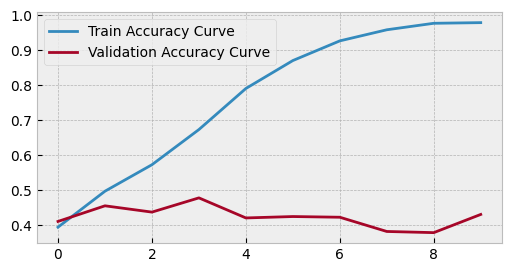

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(6,3))
plt.plot(train_accuracies, label='Train Accuracy Curve')
plt.plot(val_accuracies, label='Validation Accuracy Curve')
plt.legend()
plt.show()

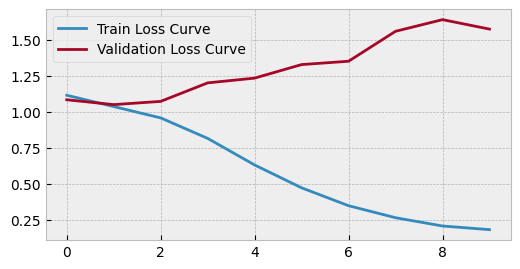

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(train_losses, label='Train Loss Curve')
plt.plot(val_losses, label='Validation Loss Curve')
plt.legend()
plt.show()

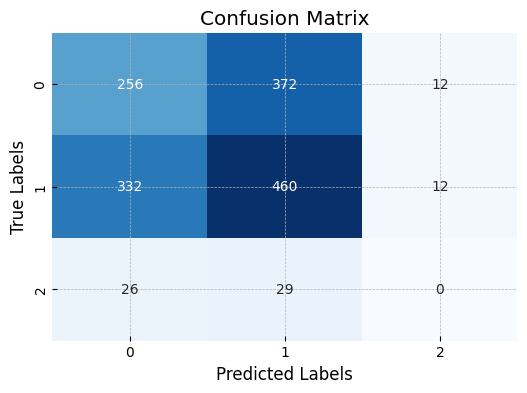

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(val_true_labels, val_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()